In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
import matplotlib as mpl
import copy

In [2]:
experiment = pd.DataFrame({
    "Trial": [1, 51, 101, 151, 201],
    "TrialEnd": np.array([51, 101, 151, 201, 251]) - 1,
    "Type": ["NormalGradual", "Trajectory", "EndPos", "RL", "NormalSudden"]
})

n_attempts = 250

attempts = list(range(1, n_attempts + 1))

types = []
for i in range(len(experiment)):
    start = experiment["Trial"][i]
    end = experiment["Trial"][i + 1] if i + 1 < len(experiment) else n_attempts + 1
    types.extend([experiment["Type"][i]] * (end - start))

full_experiment = pd.DataFrame({ "Trial": attempts, "Type": types })

In [3]:
subject1 = pd.read_csv("Subject_2.csv")
subject1 = pd.merge(subject1, full_experiment, on = "Trial")

subject2 = pd.read_csv("Subject_1.csv")
subject2 = pd.merge(subject2, full_experiment, on = "Trial")

subject1

,Trial,Score,TotalScore,FeedbackType,EndPosX,EndPosY,Perturbation,PerturbationForce,Type
0,1,0,0,NaN,546.921285,634.921285,NaN,0.0,NormalGradual
1,2,0,0,NaN,670.307986,570.941507,NaN,0.0,NormalGradual
2,3,0,0,NaN,482.466692,529.955589,NaN,0.0,NormalGradual
3,4,-50,-50,NaN,-88.027370,10.861823,NaN,0.0,NormalGradual
4,5,-50,-100,NaN,7.920418,201.503216,NaN,0.0,NormalGradual
...,...,...,...,...,...,...,...,...,...
245,246,0,3616,NaN,352.711425,412.918051,NaN,0.0,NormalSudden
246,247,93,3709,NaN,171.986656,258.684030,NaN,0.0,NormalSudden
247,248,0,3709,NaN,279.990012,397.250011,NaN,0.0,NormalSudden
248,249,93,3802,NaN,93.936223,303.453205,NaN,0.0,NormalSudden


In [4]:
screen_width, screen_height = 1680, 1050
table_width = screen_width - 100
table_height = int(screen_height * 0.9)

zone_width = int(table_width * 0.95)
zone_height = 150

scoring_rect = {
    "x": (screen_width - zone_width) // 2,
    "y": int(table_height * 0.2),
    "width": zone_width,
    "height": zone_height
}

# Calculate the corner properties
scoring_rect["topleft"] = (scoring_rect["x"], scoring_rect["y"])
scoring_rect["topright"] = (scoring_rect["x"] + scoring_rect["width"], scoring_rect["y"])
scoring_rect["bottomleft"] = (scoring_rect["x"], scoring_rect["y"] + scoring_rect["height"])
scoring_rect["bottomright"] = (scoring_rect["x"] + scoring_rect["width"], scoring_rect["y"] + scoring_rect["height"])

green_triangle = [
    scoring_rect["topleft"],
    scoring_rect["topright"],
    scoring_rect["bottomleft"]
]

red_triangle = [
    scoring_rect["bottomright"],
    scoring_rect["bottomleft"],
    scoring_rect["topright"]
]

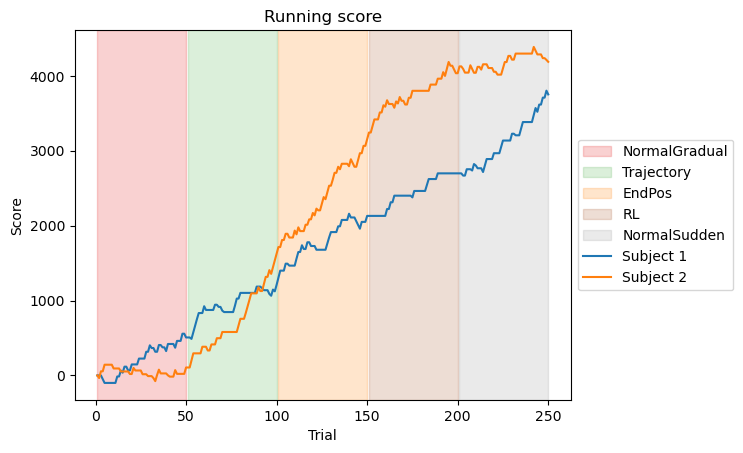

In [5]:
fig, axs = plt.subplots(nrows = 1, ncols = 1)

color_map = mpl.colormaps["Set1"]
n_colors = len(experiment.Type.unique())
colors = [color_map(idx / (n_colors - 1)) for idx in range(n_colors)]
colors = dict(zip(experiment.Type.unique(), colors))
unique_periods = experiment.Type.unique()

# Show the different experimental periods
for i, change in experiment.iterrows():
    label = change.Type if change.Type in unique_periods else ""
    unique_periods = unique_periods[unique_periods != change.Type]

    start = change.Trial
    end = change.TrialEnd

    axs.axvspan(
        start, end,
        alpha = 0.2,
        label = label,
        color = colors.get(change.Type)
    )

axs.plot(
    subject1.Trial,
    subject1.TotalScore,
    label = "Subject 1"
)

axs.plot(
    subject2.Trial,
    subject2.TotalScore,
    label = "Subject 2"
)

axs.legend(loc = "center left", bbox_to_anchor = (1, 0.5))

axs.set_xlabel("Trial")
axs.set_ylabel("Score")
plt.title("Running score")
plt.show()

In [6]:
means1 = subject1.groupby("Type").mean("Score").reset_index(drop = False)[["Type", "Score", "Trial"]]
means2 = subject2.groupby("Type").mean("Score").reset_index(drop = False)[["Type", "Score", "Trial"]]

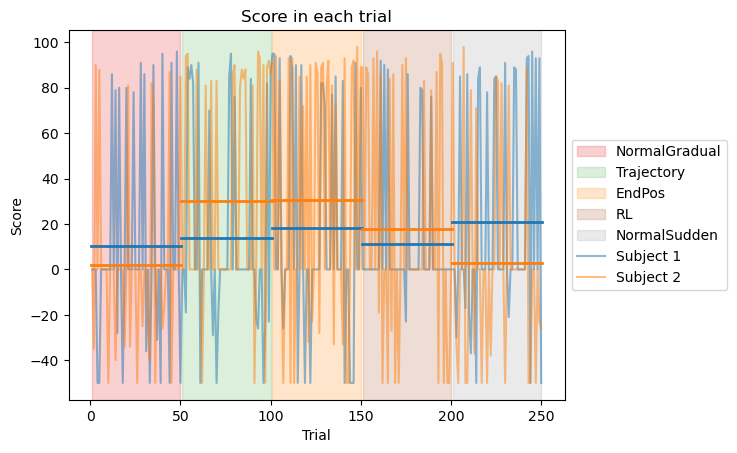

In [7]:
fig, axs = plt.subplots(nrows = 1, ncols = 1)

unique_periods = experiment.Type.unique()

# Show the different experimental periods
for i, change in experiment.iterrows():
    label = change.Type if change.Type in unique_periods else ""
    unique_periods = unique_periods[unique_periods != change.Type]

    start = change.Trial
    end = change.TrialEnd

    axs.axvspan(
        start, end,
        alpha = 0.2,
        label = label,
        color = colors.get(change.Type)
    )

axs.plot(
    subject1.Trial,
    subject1.Score,
    label = "Subject 1",
    alpha = 0.5
)

axs.plot(
    subject2.Trial,
    subject2.Score,
    label = "Subject 2",
    alpha = 0.5
)

for i, mean in means1.iterrows():
    axs.plot(
        [mean.Trial - 50 / 2, mean.Trial + 50 / 2], [mean.Score, mean.Score],
        color = "#1f77b4", linestyle = "-", linewidth = 2
    )

for i, mean in means2.iterrows():
    axs.plot(
        [mean.Trial - 50 / 2, mean.Trial + 50 / 2], [mean.Score, mean.Score],
        color = "#ff7f0e", linestyle = "-", linewidth = 2
    )

axs.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
axs.set_xlabel("Trial")
axs.set_ylabel("Score")
plt.title("Score in each trial")
plt.show()

In [8]:
def plot_ellipse_around_points(x, y, ax, color, nstd = 2, **kwargs):
    cov = np.cov(x, y)
    pos = (np.mean(x), np.mean(y))

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * nstd * np.sqrt(eigvals)
    
    ellipse = Ellipse(xy = pos, width = width, height = height, angle = angle, **kwargs)
    
    ax.scatter(pos[0], pos[1], marker = "x", color = color)
    ax.add_patch(ellipse)

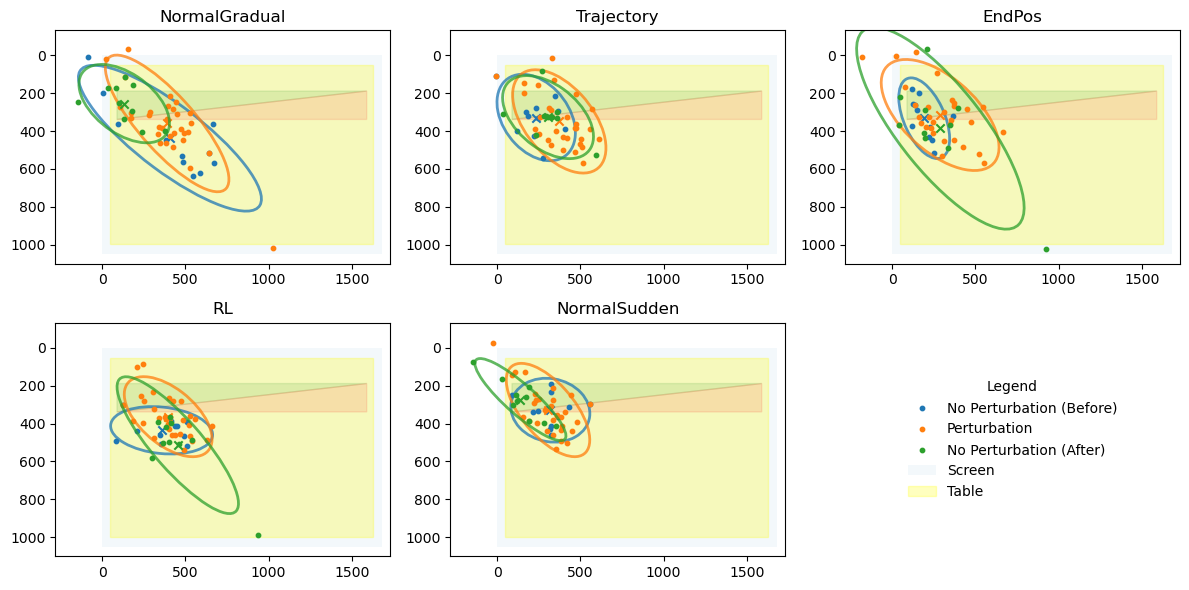

In [9]:
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

min_pos_x = subject1.EndPosX.min() - 100
max_pos_x = screen_width + 50

min_pos_y = subject1.EndPosY.min() - 100
max_pos_y = screen_height + 50

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

screen = Rectangle((0, 0), screen_width, screen_height, alpha = 0.05, label = "Screen")
table = Rectangle(
    ((screen_width - table_width) // 2, (screen_height - table_height) // 2),
    table_width, table_height,
    alpha = 0.25,
    color = "yellow",
    label = "Table"
)

green_x, green_y = zip(*green_triangle)
red_x, red_y = zip(*red_triangle)

# To collect legend entries
legend_handles = []

for (i, feedback), ax in zip(enumerate(subject1.Type.unique()), axs.flatten()[:-1]):  # Exclude the last subplot
    screen_ = copy.deepcopy(screen)
    table_ = copy.deepcopy(table)

    ax.add_patch(screen_)
    ax.add_patch(table_)
    ax.fill(green_x, green_y, color = "green", alpha = 0.1)
    ax.fill(red_x, red_y, color = "red", alpha = 0.1)

    group_data = subject1[subject1.Type == feedback].reset_index(drop = True).sort_values(by = "Trial")
    no_perturb_before = group_data.loc[:10]
    perturb = group_data.loc[10:40]
    no_perturb_after = group_data.loc[40:]

    scatter_before = ax.scatter(
        no_perturb_before.EndPosX,
        no_perturb_before.EndPosY,
        label = "No Perturbation (Before)",
        c = default_colors[0],
        s = 10
    )
    plot_ellipse_around_points(
        no_perturb_before.EndPosX, no_perturb_before.EndPosY,
        ax = ax,
        color = default_colors[0],
        alpha = 0.75,
        edgecolor = default_colors[0],
        facecolor = "none",
        lw = 2
    )
    scatter_perturb = ax.scatter(
        perturb.EndPosX,
        perturb.EndPosY,
        label = "Perturbation",
        c = default_colors[1],
        s = 10
    )
    plot_ellipse_around_points(
        perturb.EndPosX, perturb.EndPosY,
        ax = ax,
        color = default_colors[1],
        alpha = 0.75,
        edgecolor = default_colors[1],
        facecolor = "none",
        lw = 2
    )
    scatter_after = ax.scatter(
        no_perturb_after.EndPosX,
        no_perturb_after.EndPosY,
        label = "No Perturbation (After)",
        c = default_colors[2],
        s = 10
    )
    plot_ellipse_around_points(
        no_perturb_after.EndPosX, no_perturb_after.EndPosY,
        ax = ax,
        color = default_colors[2],
        alpha = 0.75,
        edgecolor = default_colors[2],
        facecolor = "none",
        lw = 2
    )
    
    ax.set_xlim(min_pos_x, max_pos_x)
    ax.set_ylim(min_pos_y, max_pos_y)

    ax.set_title(feedback)
    ax.invert_yaxis()

    # Collect handles for the legend
    if i == 0:
        legend_handles.extend([scatter_before, scatter_perturb, scatter_after, screen_, table_])

# Hide the 6th subplot and use it for the legend
axs[1, 2].axis("off")
axs[1, 2].legend(handles = legend_handles, loc = "center", frameon = False, title = "Legend")

fig.tight_layout()
plt.show()

TODO: perform statistical tests to see if there is a difference in the means between the groups.

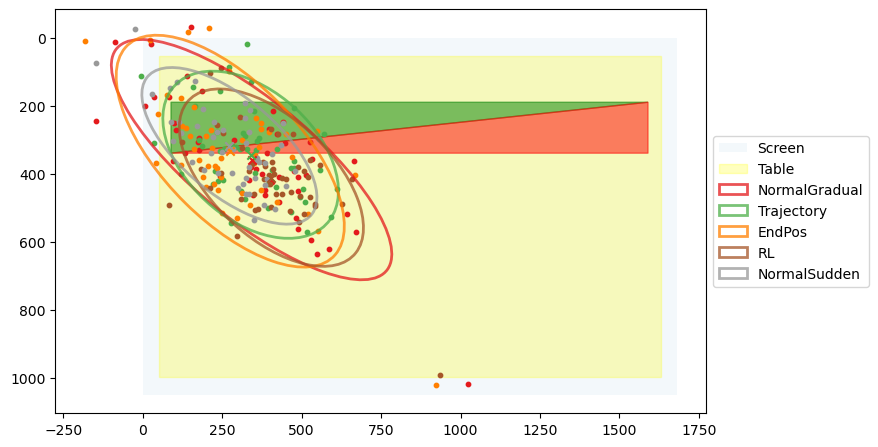

In [10]:
fig, ax = plt.subplots(figsize = (screen_width / 200, screen_height / 200))

screen = Rectangle((0, 0), screen_width, screen_height, alpha = 0.05, label = "Screen")
ax.add_patch(screen)

table = Rectangle(
    ((screen_width - table_width) // 2, (screen_height - table_height) // 2),
    table_width, table_height,
    alpha = 0.25,
    color = "yellow",
    label = "Table"
)
ax.add_patch(table)

green_x, green_y = zip(*green_triangle)
ax.fill(green_x, green_y, color = "green", alpha = 0.5)

red_x, red_y = zip(*red_triangle)
ax.fill(red_x, red_y, color = "red", alpha = 0.5)

for feedback in subject1.Type.unique():
    group_data = subject1[subject1.Type == feedback]
    ax.scatter(
        group_data.EndPosX,
        group_data.EndPosY,
        color = colors.get(feedback),
        s = 10
    )

for feedback in subject1.Type.unique():
    group_data = subject1[subject1.Type == feedback]
    ellipse = plot_ellipse_around_points(
        group_data.EndPosX, group_data.EndPosY,
        ax = ax,
        color = colors.get(feedback),
        alpha = 0.75,
        edgecolor = colors.get(feedback),
        facecolor = "none",
        lw = 2,
        label = feedback
    )

plt.gca().invert_yaxis()
plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

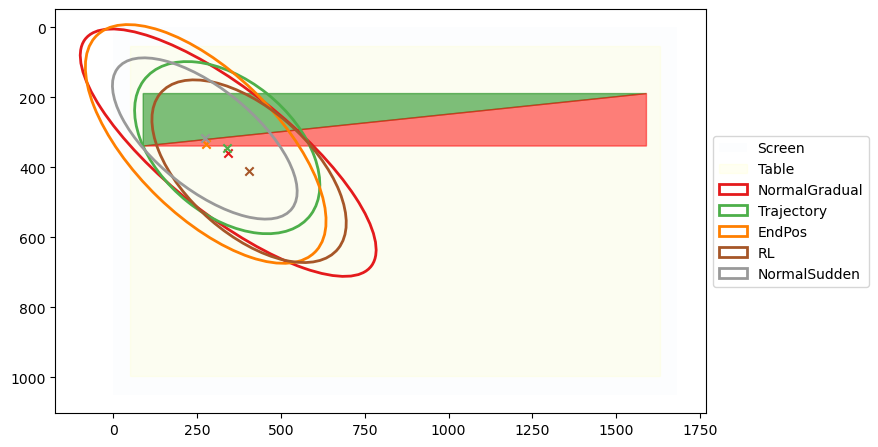

In [11]:
fig, ax = plt.subplots(figsize = (screen_width / 200, screen_height / 200))

screen = Rectangle((0, 0), screen_width, screen_height, alpha = 0.01, label = "Screen")
ax.add_patch(screen)

table = Rectangle(
    ((screen_width - table_width) // 2, (screen_height - table_height) // 2),
    table_width, table_height,
    alpha = 0.05,
    color = "yellow",
    label = "Table"
)
ax.add_patch(table)

green_x, green_y = zip(*green_triangle)
ax.fill(green_x, green_y, color = "green", alpha = 0.5)

red_x, red_y = zip(*red_triangle)
ax.fill(red_x, red_y, color = "red", alpha = 0.5)

# for feedback in subject1.Type.unique():
#     group_data = subject1[subject1.Type == feedback]
#     ax.scatter(
#         group_data.EndPosX,
#         group_data.EndPosY,
#         color = colors.get(feedback),
#         s = 10
#     )

for feedback in subject1.Type.unique():
    group_data = subject1[subject1.Type == feedback]
    ellipse = plot_ellipse_around_points(
        group_data.EndPosX, group_data.EndPosY,
        ax = ax,
        color = colors.get(feedback),
        alpha = 1,
        edgecolor = colors.get(feedback),
        facecolor = "none",
        lw = 2,
        label = feedback
    )

plt.gca().invert_yaxis()
plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()